# Compas Analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

Modified from original https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb?short_path=0bb3511

## Provided dataset

1. compas.db - SQLite database with complete data
2. compas-scores-two-years.csv - Filtered dataset for two-year recidivism analysis
3. compas-scores-two-years-violent.csv - Violent recidivism subset
4. compas-scores-raw.csv - Raw COMPAS scores

In [1]:
# dependencies
!pip install missingno statsmodels
# !pip install pandas


[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# filter dplyr warnings
import sys
sys.path.insert(0, "./datasets/compas-analysis")
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.formula.api import glm
from datetime import datetime

warnings.filterwarnings('ignore')

# compas-scores-two-years.csv Investigation

In [3]:
# Read dataset
df = pd.read_csv("./datasets/compas-analysis/compas-scores-two-years.csv")
print(df.head())



   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custody  out_custody  pr

In [4]:
print(df.describe())

                 id          age  juv_fel_count  decile_score  juv_misd_count  \
count   7214.000000  7214.000000    7214.000000   7214.000000     7214.000000   
mean    5501.255753    34.817993       0.067230      4.509565        0.090934   
std     3175.706870    11.888922       0.473972      2.856396        0.485239   
min        1.000000    18.000000       0.000000      1.000000        0.000000   
25%     2735.250000    25.000000       0.000000      2.000000        0.000000   
50%     5509.500000    31.000000       0.000000      4.000000        0.000000   
75%     8246.500000    42.000000       0.000000      7.000000        0.000000   
max    11001.000000    96.000000      20.000000     10.000000       13.000000   

       juv_other_count  priors_count  days_b_screening_arrest  \
count      7214.000000   7214.000000              6907.000000   
mean          0.109371      3.472415                 3.304763   
std           0.501586      4.882538                75.809505   
min       

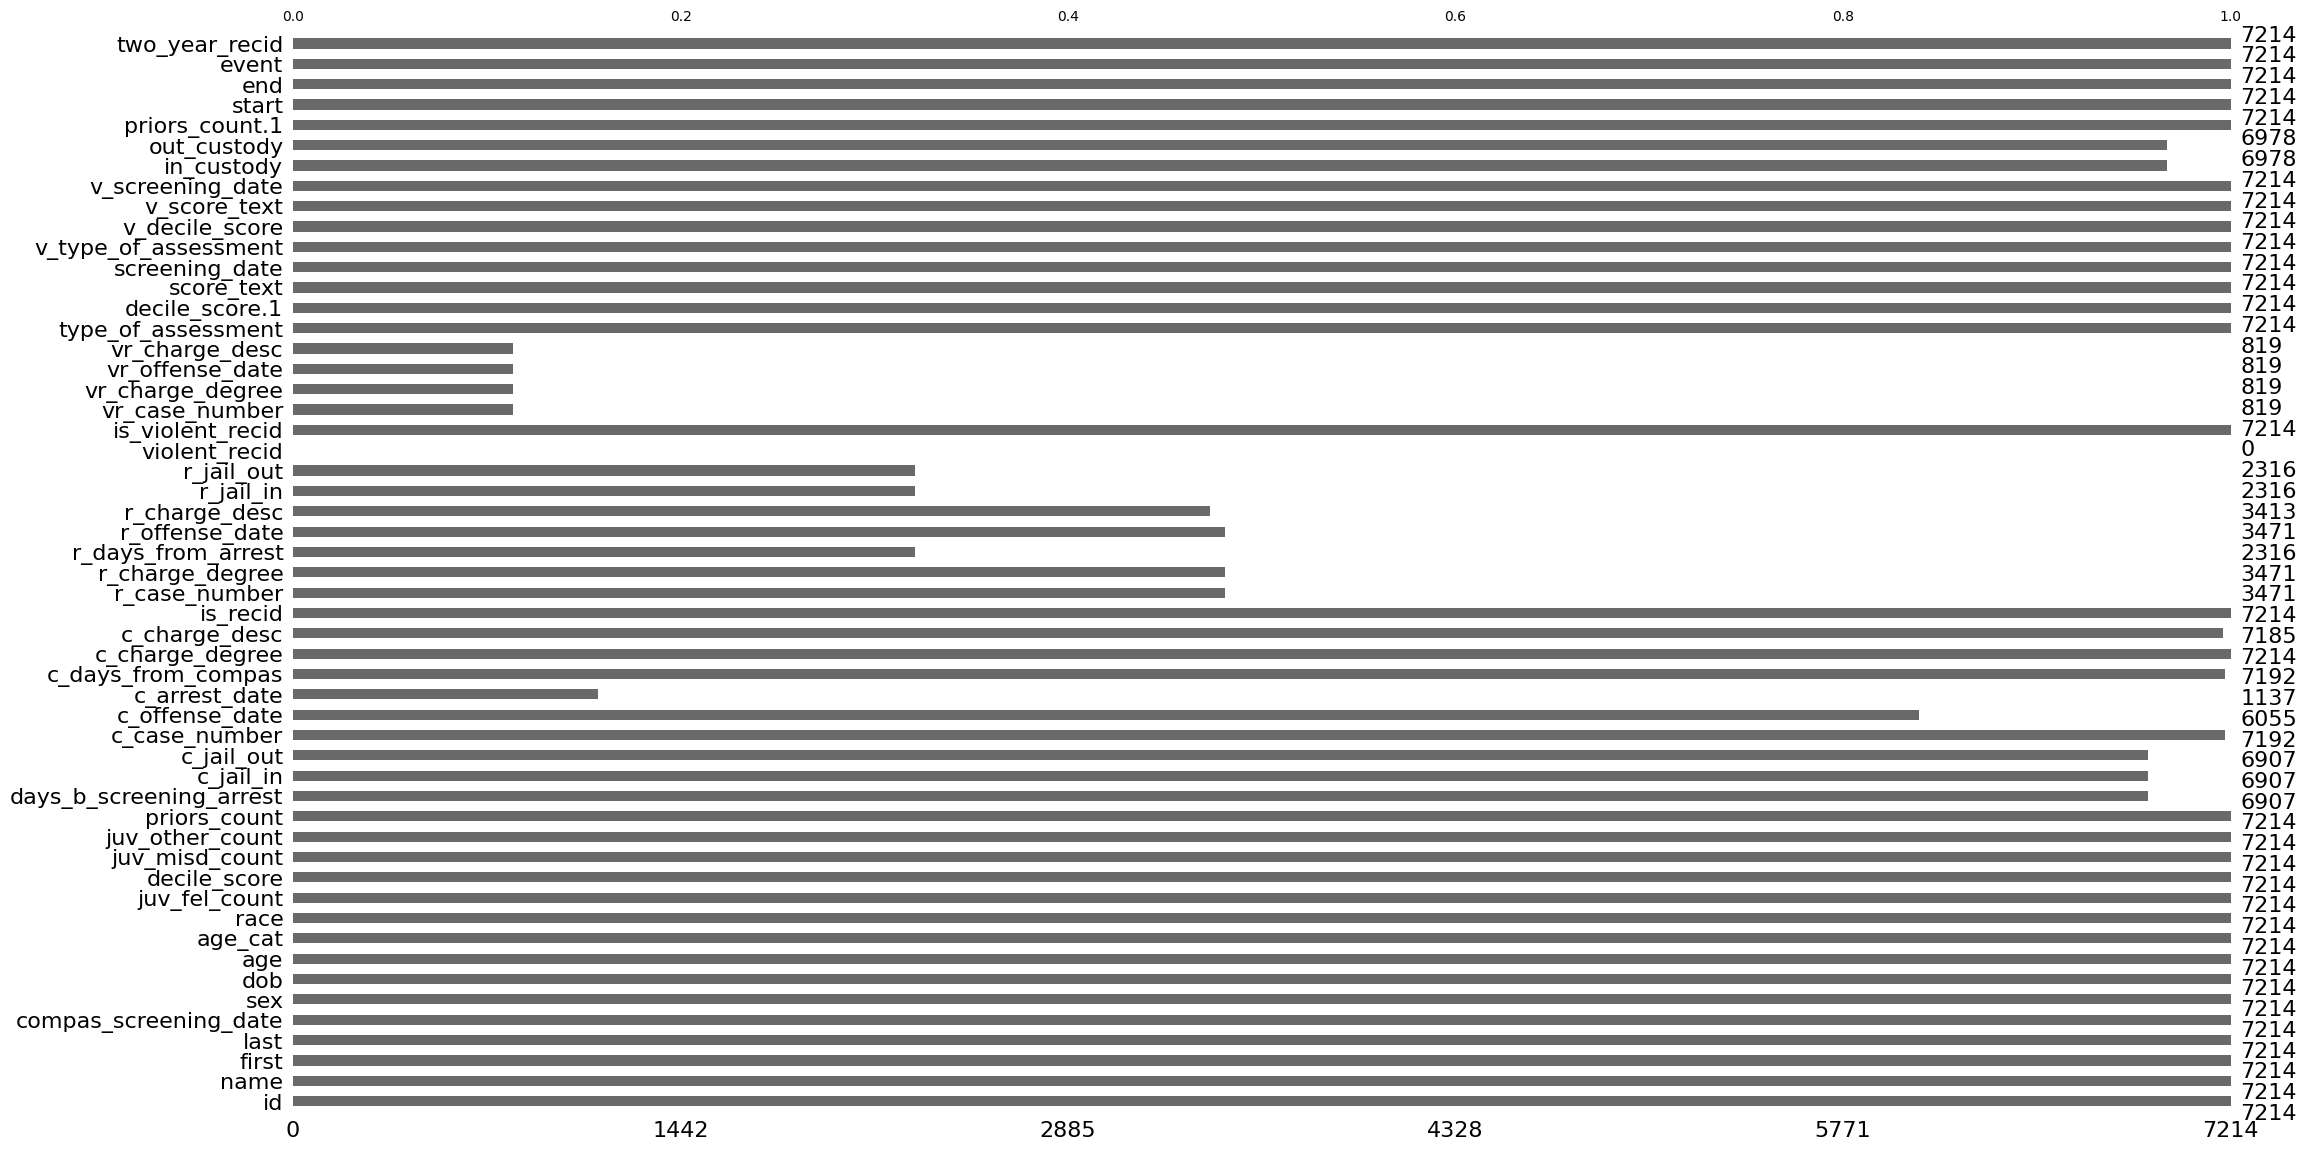

In [5]:
# Check missing data
# print(df.info()) 
# The fuller the bar graph --> more filled the data
import missingno as msno  
msno.bar(df)
plt.show()

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [6]:

cleaned_df = df[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Charge Date Mismatch clean (±30 day window)
cleaned_df= cleaned_df[cleaned_df["days_b_screening_arrest"] <= 30 ]
cleaned_df= cleaned_df[ cleaned_df["days_b_screening_arrest"] >= -30]

# Missing COMPAS Cases 
cleaned_df = cleaned_df[cleaned_df["is_recid"]!= -1]

# Ordinary Traffic Offenses 
cleaned_df = cleaned_df[cleaned_df["c_charge_degree" ] != "O"]

# Missing score_text
cleaned_df = cleaned_df[cleaned_df["score_text"] != 'N/A']

# It is already the dataset of 2 years period so we dont need to filter it out
cleaned_df.head()


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30


Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [7]:

# create new column length of stay
# subtract time to get the difference --> get the time stayed

print(type(cleaned_df["c_jail_in"][0]))
cleaned_df["c_jail_in"] = pd.to_datetime(cleaned_df["c_jail_in"])
cleaned_df["c_jail_out"] = pd.to_datetime(cleaned_df["c_jail_out"])
# cleaned_df["length_of_stay"] 

# Calculate length of stay
cleaned_df["length_of_stay"] = (cleaned_df["c_jail_out"] - cleaned_df["c_jail_in"]).dt.days

# Calculate correlation
correlation = cleaned_df["length_of_stay"].corr(cleaned_df["decile_score"])
print(f"Correlation: {correlation}")

cleaned_df.head()


<class 'str'>
Correlation: 0.2074780847803184


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,length_of_stay
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,10
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,1
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,6


After filtering we have the following demographic breakdown:

In [8]:
cleaned_df["age_cat"].value_counts()

age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

In [9]:
# African American take the most proportion in the dataset
cleaned_df["race"].value_counts()

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

In [10]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [11]:
cleaned_df["score_text"].value_counts()

score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64

In [12]:
race_sex_table = pd.crosstab(cleaned_df["race"], cleaned_df["sex"])
print(race_sex_table)

sex               Female  Male
race                          
African-American     549  2626
Asian                  2    29
Caucasian            482  1621
Hispanic              82   427
Native American        2     9
Other                 58   285


In [13]:
cleaned_df["sex"].value_counts()

sex
Male      4997
Female    1175
Name: count, dtype: int64

In [14]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [15]:
# total of two year recid prisioner
(cleaned_df[cleaned_df["two_year_recid"] == 1])["two_year_recid"].value_counts()

two_year_recid
1    2809
Name: count, dtype: int64

In [16]:
# %%R
# nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100
# count of people are true to two_year_recid to all
print((cleaned_df[cleaned_df["two_year_recid"] == 1])["two_year_recid"].value_counts())
# total count
print(cleaned_df["two_year_recid"].value_counts())
# In total 83% of those people did have two year recid 
print(2809/3363 * 100)

two_year_recid
1    2809
Name: count, dtype: int64
two_year_recid
0    3363
1    2809
Name: count, dtype: int64
83.52661314302706


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

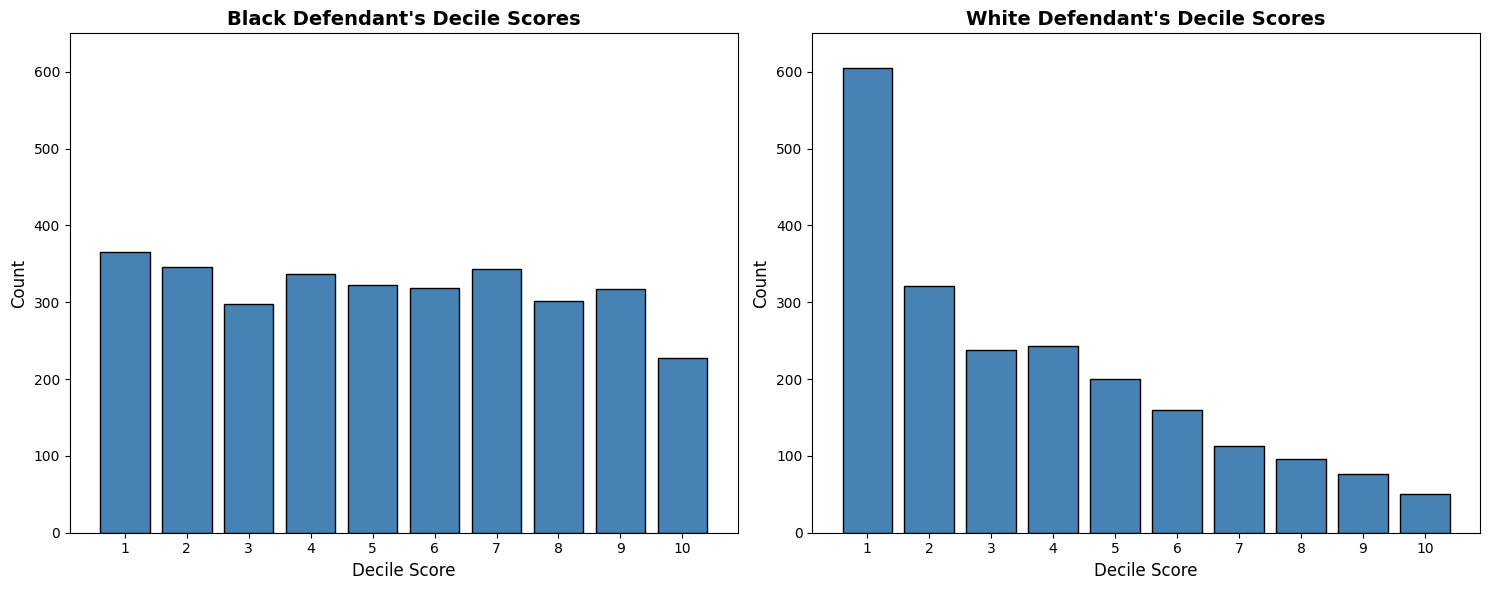

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Black defendants
black_df = cleaned_df[cleaned_df["race"] == "African-American"]
black_counts = black_df["decile_score"].value_counts().sort_index()
ax1.bar(black_counts.index, black_counts.values, color='steelblue', edgecolor='black')
ax1.set_xlabel("Decile Score", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_ylim(0, 650)
ax1.set_title("Black Defendant's Decile Scores", fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 11))

# White defendants
white_df = cleaned_df[cleaned_df["race"] == "Caucasian"]
white_counts = white_df["decile_score"].value_counts().sort_index()
ax2.bar(white_counts.index, white_counts.values, color='steelblue', edgecolor='black')
ax2.set_xlabel("Decile Score", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_ylim(0, 650)
ax2.set_title("White Defendant's Decile Scores", fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

In [18]:
decile_score_race_table = pd.crosstab(cleaned_df["decile_score"], cleaned_df["race"])
print(decile_score_race_table)

race          African-American  Asian  Caucasian  Hispanic  Native American  \
decile_score                                                                  
1                          365     15        605       159                0   
2                          346      4        321        89                2   
3                          298      5        238        73                1   
4                          337      0        243        47                0   
5                          323      1        200        39                0   
6                          318      2        160        27                2   
7                          343      1        113        28                2   
8                          301      2         96        14                0   
9                          317      0         77        17                2   
10                         227      1         50        16                2   

race          Other  
decile_score         
1      

## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [19]:
cleaned_df.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out,length_of_stay
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53,10
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04,1
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,1
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30,6


In [20]:
# Create factor variables (categorical encodings)
df_model = cleaned_df.copy()
# Convert to categorical and set reference levels
df_model['crime_factor'] = pd.Categorical(df_model['c_charge_degree'])

df_model['age_factor'] = pd.Categorical(df_model['age_cat'])
# Reorder categories to make category at index 0 the reference
age_categories = df_model['age_factor'].cat.categories.tolist()
df_model['age_factor'] = df_model['age_factor'].cat.reorder_categories(
    [age_categories[0]] + [cat for cat in age_categories if cat != age_categories[0]]
)

df_model['race_factor'] = pd.Categorical(df_model['race'])
# Set the 3rd category (index 2) as reference
race_categories = df_model['race_factor'].cat.categories.tolist()
df_model['race_factor'] = df_model['race_factor'].cat.reorder_categories(
    [race_categories[2]] + [cat for cat in race_categories if cat != race_categories[2]]
)

df_model['gender_factor'] = pd.Categorical(df_model['sex'], 
                                            categories=['Male', 'Female'])
# Set 'Male' as reference
df_model.head()

df_model['gender_factor'] = df_model['gender_factor'].cat.reorder_categories(['Male', 'Female'])

df_model['score_factor'] = (df_model['score_text'] != 'Low').map({False: 'LowScore', True: 'HighScore'})
df_model['score_factor'] = pd.Categorical(df_model['score_factor'])


# put in glm model
model = glm(formula='score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid',
                data=df_model, 
                family=sm.families.Binomial())

result = model.fit()
print(result.summary())


                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['score_factor[HighScore]', 'score_factor[LowScore]']   No. Observations:                 6172
Model:                                                               GLM   Df Residuals:                     6160
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     Logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -3084.2
Date:                                                   Fri, 06 Feb 2026   Deviance:                       6168.4
Time:                                                           15:46:49   Pearson chi2:                 6.07e+03
No. Iterations:                                                        6   Pseudo R-squ.

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [21]:
control = np.exp(-1.52554) / (1 + np.exp(-1.52554))
result = np.exp(0.47721) / (1 - control + (control * np.exp(0.47721)))
print(f"Control: {control}")
print(f"Result: {result}")

Control: 0.17864717443340628
Result: 1.4528408658138932


Women are 19.4% more likely than men to get a higher score.

In [22]:
result = np.exp(0.2213) / (1 - control + (control * np.exp(0.2213)))
result

np.float64(1.1948260442387293)

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [23]:
np.exp(1.3084) / (1 - control + (control * np.exp(1.3084)))

np.float64(2.496134038108904)

### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [24]:
# %%R
# raw_data <- read.csv("./compas-scores-two-years-violent.csv")
# nrow(raw_data)
# Read dataset
df_vi = pd.read_csv("./datasets/compas-analysis/compas-scores-two-years-violent.csv")
print(df_vi.head())

   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   5         marcu brown   marcu        brown            2013-01-13  Male   
3   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   
4   7        marsha miles  marsha        miles            2013-11-30  Male   

          dob  age          age_cat              race  ...  v_score_text  \
0  1947-04-18   69  Greater than 45             Other  ...           Low   
1  1982-01-22   34          25 - 45  African-American  ...           Low   
2  1993-01-21   23     Less than 25  African-American  ...        Medium   
3  1973-01-22   43          25 - 45             Other  ...           Low   
4  1971-08-22   44          25 - 45             Other  ...           Low   

   v_screening_date  in_custody  out_custody  priors_count.1  start   end 

In [25]:
# %%R
# df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, v_score_text, sex, priors_count, 
#                     days_b_screening_arrest, v_decile_score, is_recid, two_year_recid) %>% 
#         filter(days_b_screening_arrest <= 30) %>%
#         filter(days_b_screening_arrest >= -30) %>% 
#         filter(is_recid != -1) %>%
#         filter(c_charge_degree != "O") %>%
#         filter(v_score_text != 'N/A')
# nrow(df)
cleaned_df_vi = df_vi[["age", "c_charge_degree", "race", "age_cat", "v_score_text", "sex", "priors_count", "days_b_screening_arrest", "v_decile_score", "is_recid", "two_year_recid"]]

cleaned_df_vi= cleaned_df_vi[cleaned_df_vi["days_b_screening_arrest"] <= 30 ]
cleaned_df_vi= cleaned_df_vi[ cleaned_df_vi["days_b_screening_arrest"] >= -30]
# Missing COMPAS Cases 
cleaned_df_vi = cleaned_df_vi[cleaned_df_vi["is_recid"]!= -1]
# Ordinary Offenses 
cleaned_df_vi = cleaned_df_vi[cleaned_df_vi["c_charge_degree" ] != "O"]
# Missing score_text
cleaned_df_vi = cleaned_df_vi[cleaned_df_vi["v_score_text"] != 'N/A']
cleaned_df_vi.head()

,age,c_charge_degree,race,age_cat,v_score_text,sex,priors_count,days_b_screening_arrest,v_decile_score,is_recid,two_year_recid
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,1,1,1
4,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0
5,43,F,Other,25 - 45,Low,Male,3,-1.0,3,0,0
6,39,M,Caucasian,25 - 45,Low,Female,0,-1.0,1,0,0


In [26]:
# %%R
# summary(df$age_cat)
cleaned_df_vi["age_cat"].value_counts()

age_cat
25 - 45            2300
Greater than 45     954
Less than 25        766
Name: count, dtype: int64

In [27]:
# %%R
# summary(df$race)
cleaned_df_vi["race"].value_counts()

race
African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: count, dtype: int64

In [28]:
# %%R
# summary(df$v_score_text)
cleaned_df_vi["v_score_text"].value_counts()

v_score_text
Low       2913
Medium     828
High       279
Name: count, dtype: int64

In [29]:
# %%R
# nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100
recid_count = len(cleaned_df_vi[cleaned_df_vi['two_year_recid'] == 1]) / len(cleaned_df_vi) * 100
print(recid_count)

16.218905472636816


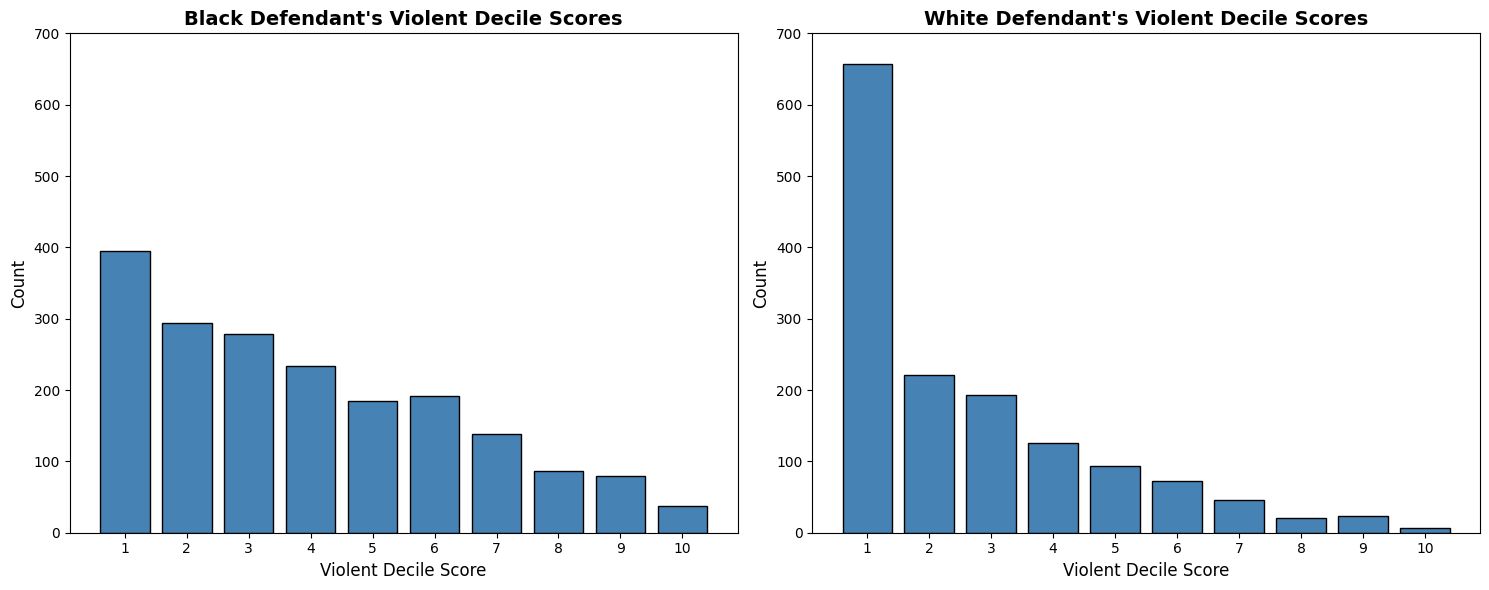

In [30]:
# Create visualizations for violent decile scores by race
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Black defendants
black_df_vi = cleaned_df_vi[cleaned_df_vi["race"] == "African-American"]
black_counts_vi = black_df_vi["v_decile_score"].value_counts().sort_index()
ax1.bar(black_counts_vi.index, black_counts_vi.values, color='steelblue', edgecolor='black')
ax1.set_xlabel("Violent Decile Score", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_ylim(0, 700)
ax1.set_title("Black Defendant's Violent Decile Scores", fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 11))

# White defendants
white_df_vi = cleaned_df_vi[cleaned_df_vi["race"] == "Caucasian"]
white_counts_vi = white_df_vi["v_decile_score"].value_counts().sort_index()
ax2.bar(white_counts_vi.index, white_counts_vi.values, color='steelblue', edgecolor='black')
ax2.set_xlabel("Violent Decile Score", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_ylim(0, 700)
ax2.set_title("White Defendant's Violent Decile Scores", fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

In [31]:
df_model_vi = cleaned_df_vi.copy()
df_model_vi['crime_factor'] = pd.Categorical(
    df_model_vi['c_charge_degree']
)
df_model_vi['age_factor'] = pd.Categorical(
    df_model_vi['age_cat'],
    categories=[
        '25 - 45',
        'Less than 25',
        'Greater than 45'
    ]
)

df_model_vi['race_factor'] = pd.Categorical(
    df_model_vi['race'],
    categories=[
        'Caucasian',
        'African-American',
        'Asian',
        'Hispanic',
        'Native American',
        'Other'
    ],
    ordered=False
)

df_model_vi['gender_factor'] = pd.Categorical(
    df_model_vi['sex'],
    categories=['Male', 'Female'],
    ordered=False
)
df_model_vi['score_factor'] = pd.Categorical(
    (df_model_vi['v_score_text'] != 'Low')
        .map({True: 'LowScore', False: 'HighScore'}),
    categories=['LowScore', 'HighScore']
)
model_vi = glm(
    formula="""
        score_factor ~ gender_factor
                      + age_factor
                      + race_factor
                      + priors_count
                      + crime_factor
                      + two_year_recid
    """,
    data=df_model_vi,
    family=sm.families.Binomial()
)

result_vi = model_vi.fit()
print(result_vi.summary())

                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['score_factor[LowScore]', 'score_factor[HighScore]']   No. Observations:                 4020
Model:                                                               GLM   Df Residuals:                     4008
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     Logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -1499.4
Date:                                                   Fri, 06 Feb 2026   Deviance:                       2998.8
Time:                                                           15:46:49   Pearson chi2:                 3.83e+03
No. Iterations:                                                        6   Pseudo R-squ.

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [32]:
# Calculate violent recidivism odds ratio for black defendants
control_vi = np.exp(-2.24274) / (1 + np.exp(-2.24274))
violent_odds_ratio = np.exp(0.65893) / (1 - control_vi + (control_vi * np.exp(0.65893)))
print(f"Black defendants violent recidivism odds ratio: {violent_odds_ratio:.4f}")
print(f"Overprediction: {(violent_odds_ratio - 1) * 100:.1f}%")

Black defendants violent recidivism odds ratio: 1.7739
Overprediction: 77.4%


Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [33]:
# Calculate age under 25 odds ratio for violent recidivism
age_under_25_odds = np.exp(3.14591) / (1 - control_vi + (control_vi * np.exp(3.14591)))
print(f"Age under 25 violent recidivism odds ratio: {age_under_25_odds:.2f}")

Age under 25 violent recidivism odds ratio: 7.41


## Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [34]:
# Load cox model data
cox_data = pd.read_csv("./datasets/compas-analysis/cox-parsed.csv")

cox_data = cox_data[cox_data["score_text"] != "N/A"]
cox_data = cox_data[cox_data["end"] > cox_data["start"]]
cox_data["race_factor"] = pd.Categorical(
    cox_data["race"],
    categories=[
        "Caucasian",         
        "African-American",
        "Asian",
        "Hispanic",
        "Native American",
        "Other"
    ],
    ordered=False
)

cox_data["score_factor"] = pd.Categorical(
    cox_data["score_text"],
    categories=[
        "Medium",  
        "Low",
        "High"
    ],
    ordered=False
)

cox_data = cox_data.sort_values(["id", "start"])
cox_grp = cox_data.drop_duplicates(subset="id", keep="first")
print(f"Number of unique defendants: {len(cox_grp)}")


Number of unique defendants: 10325


In [35]:
# Summary of score factor
print(cox_grp['score_factor'].value_counts())

score_factor
Low       5751
Medium    2611
High      1952
Name: count, dtype: int64


In [36]:
# Summary of race factor
print(cox_grp['race_factor'].value_counts())

race_factor
African-American    5150
Caucasian           3576
Hispanic             944
Other                572
Asian                 51
Native American       32
Name: count, dtype: int64


In [37]:
!pip install lifelines


[notice] A new release of pip is available: 25.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [38]:
from lifelines import CoxPHFitter

cox_data_model = cox_data.copy()
cox_data_model["score_factor"] = pd.Categorical(
    cox_data_model["score_text"],
    categories=["Low", "Medium", "High"], 
    ordered=False
)
cox_data_model = pd.get_dummies(
    cox_data_model,
    columns=["score_factor"],
    drop_first=True  
)
cph = CoxPHFitter()
cph.fit(
    cox_data_model[
        ["start", "end", "event", "score_factor_Medium", "score_factor_High"]
    ],
    duration_col="end",
    event_col="event",
    entry_col="start"
)

print(cph.summary)


                         coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
score_factor_Medium  0.796990   2.218853  0.040758        0.717107   
score_factor_High    1.250383   3.491681  0.041444        1.169154   

                     coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
score_factor_Medium        0.876874             2.048498             2.403375   
score_factor_High          1.331612             3.219269             3.787144   

                     cmp to          z              p    -log2(p)  
covariate                                                          
score_factor_Medium     0.0  19.554348   3.788139e-85  280.442399  
score_factor_High       0.0  30.170365  5.799725e-200  661.849634  


People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [39]:
# Cox model with decile score
cph_decile = CoxPHFitter()
cph_decile.fit(cox_data[['start','end', 'event', 'decile_score']], 
               duration_col='end', event_col='event',entry_col="start")
print(cph_decile.summary)

                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
decile_score  0.194837   1.215113  0.005793        0.183482        0.206192   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                   
decile_score             1.201393             1.228989     0.0  33.630321   

                          p    -log2(p)  
covariate                                
decile_score  6.048095e-248  821.241687  


COMPAS's decile scores are a bit more accurate at 66%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.

In [40]:
# Cox model with race and score
from lifelines import CoxPHFitter
cox_data_int = cox_data.copy()
cox_data_int["race_factor"] = pd.Categorical(
    cox_data_int["race"],
    categories=[
        "Caucasian",
        "African-American",
        "Asian",
        "Hispanic",
        "Native American",
        "Other"
    ],
    ordered=False
)
cox_data_int["score_factor"] = pd.Categorical(
    cox_data_int["score_text"],
    categories=["Low", "Medium", "High"],
    ordered=False
)
cox_data_int = pd.get_dummies(
    cox_data_int,
    columns=["race_factor", "score_factor"],
    drop_first=True
)
for r in [
    "race_factor_African-American",
    "race_factor_Asian",
    "race_factor_Hispanic",
    "race_factor_Native American",
    "race_factor_Other",
]:
    for s in ["score_factor_Medium", "score_factor_High"]:
        cox_data_int[f"{r}:{s}"] = (
            cox_data_int[r] * cox_data_int[s]
        )
cph_interaction = CoxPHFitter()

cph_interaction.fit(
    cox_data_int[
        ["start", "end", "event"]
        + [c for c in cox_data_int.columns
           if c.startswith("race_factor_")
           or c.startswith("score_factor_")
           or ":" in c]
    ],
    duration_col="end",
    event_col="event",
    entry_col="start"
)

print(cph_interaction.summary)


                                                      coef  exp(coef)  \
covariate                                                               
race_factor_African-American                      0.280656   1.323998   
race_factor_Asian                                -0.775350   0.460542   
race_factor_Hispanic                             -0.061934   0.939945   
race_factor_Native American                      -1.253115   0.285614   
race_factor_Other                                 0.013065   1.013151   
score_factor_Medium                               0.844434   2.326660   
score_factor_High                                 1.285047   3.614839   
race_factor_African-American:score_factor_Medium -0.174462   0.839909   
race_factor_African-American:score_factor_High   -0.191620   0.825621   
race_factor_Asian:score_factor_Medium             0.984557   2.676625   
race_factor_Asian:score_factor_High               1.313974   3.720931   
race_factor_Hispanic:score_factor_Medium          0

The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.

In [41]:
import math
print("Black High Hazard: %.2f" % (math.exp(-0.191620 + 1.285047)))
print("White High Hazard: %.2f" % (math.exp(1.285047)))
print("Black Medium Hazard: %.2f" % (math.exp(0.844434-0.174462 )))
print("White Medium Hazard: %.2f" % (math.exp(0.844434)))

Black High Hazard: 2.98
White High Hazard: 3.61
Black Medium Hazard: 1.95
White Medium Hazard: 2.33


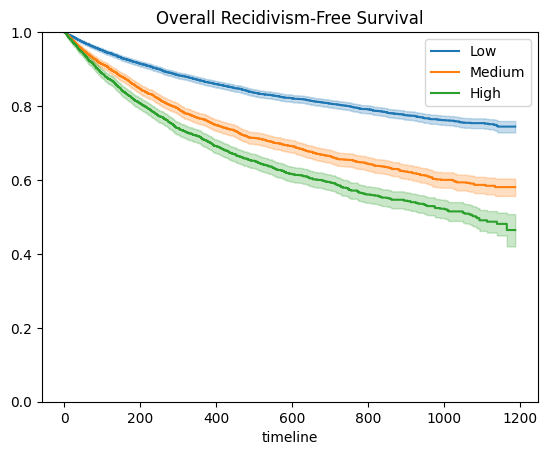

In [42]:
from lifelines import KaplanMeierFitter

# Overall Kaplan-Meier survival curve
kmf = KaplanMeierFitter()
for score_label in ['Low', 'Medium', 'High']:
    w = cox_data[cox_data['score_text'] == score_label]
    if len(w) > 0:
        kmf.fit(durations=w['end'], event_observed=w['event'], label=score_label)
        kmf.plot_survival_function()
plt.title('Overall Recidivism-Free Survival')
plt.ylim(0, 1)
plt.show()

Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.

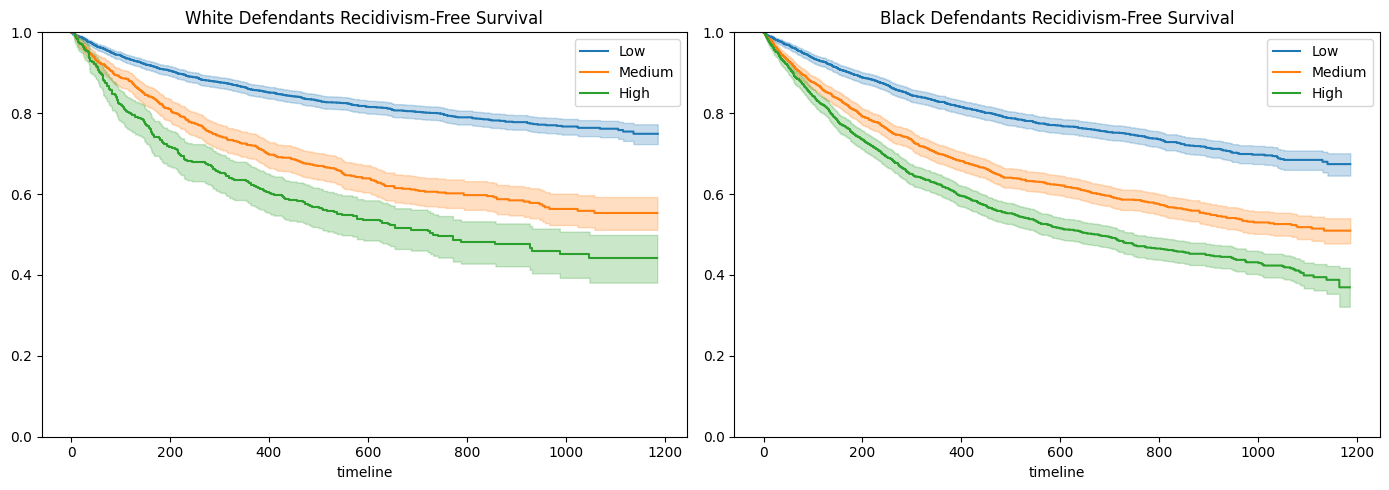

In [43]:
# Race-specific Kaplan-Meier curves (stratified by score_text: Low, Medium, High — matches R survfit(~ score_factor))
# R uses counting-process (multiple rows per id); lifelines KM needs one row per subject — collapse to match R.
def collapse_to_one_per_id(df):
    out = df.groupby('id').agg({'end': 'max', 'event': 'max', 'score_text': 'first', 'race': 'first'}).reset_index()
    out['score_factor'] = out['score_text']  # keep for downstream Cox cells
    return out
white_cx = collapse_to_one_per_id(cox_data[cox_data['race'] == 'Caucasian'])
black_cx = collapse_to_one_per_id(cox_data[cox_data['race'] == 'African-American'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for score_label in ['Low', 'Medium', 'High']:
    w = white_cx[white_cx['score_text'] == score_label]
    if len(w) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(durations=w['end'], event_observed=w['event'], label=score_label)
        kmf.plot_survival_function(ax=ax1)
    b = black_cx[black_cx['score_text'] == score_label]
    if len(b) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(durations=b['end'], event_observed=b['event'], label=score_label)
        kmf.plot_survival_function(ax=ax2)

ax1.set_title('White Defendants Recidivism-Free Survival')
ax1.set_ylim(0, 1)
ax1.legend()
ax2.set_title('Black Defendants Recidivism-Free Survival')
ax2.set_ylim(0, 1)
ax2.legend()
plt.tight_layout()
plt.show()

In [82]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

for score in ["Low","Medium","High"]:
    mask = cox_data['score_factor'] == score
    
    kmf.fit(
        durations=cox_data.loc[mask, 'end'],
        event_observed=cox_data.loc[mask, 'event'],
        entry=cox_data.loc[mask, 'start']  # this handles counting-process
    )
    
    surv_730 = kmf.predict(730)
    n_risk_730 = ((cox_data.loc[mask,'start'] <= 730) & 
                  (cox_data.loc[mask,'end'] >= 730)).sum()
    n_event_730 = ((cox_data.loc[mask,'end'] == 730) & 
                   (cox_data.loc[mask,'event'] == 1)).sum()
    n_entered = len(cox_data.loc[mask])
    n_censored = n_entered - n_event_730
    
    print(f"score_factor={score}")
    print(f"time=730, n.risk={n_risk_730}, n.event={n_event_730}, entered={n_entered}, censored={n_censored}, survival={surv_730:.2f}\n")


score_factor=Low
time=730, n.risk=2749, n.event=0, entered=6893, censored=6893, survival=0.78

score_factor=Medium
time=730, n.risk=980, n.event=0, entered=3535, censored=3535, survival=0.56

score_factor=High
time=730, n.risk=505, n.event=0, entered=2916, censored=2916, survival=0.41



In [84]:
# Function to calculate KM summary at 730 for a subset
def km_summary(data, group_label):
    from lifelines import KaplanMeierFitter

    kmf = KaplanMeierFitter()
    print(f"\n{group_label} defendants")
    
    for score in ["Low","Medium","High"]:
        mask = (data['score_factor'] == score)
        kmf.fit(
            durations=data.loc[mask, 'end'],
            event_observed=data.loc[mask, 'event'],
            entry=data.loc[mask, 'start']  # counting-process
        )
        
        surv_730 = kmf.predict(730)
        n_risk_730 = ((data.loc[mask,'start'] <= 730) & 
                      (data.loc[mask,'end'] >= 730)).sum()
        n_event_730 = ((data.loc[mask,'end'] == 730) & 
                       (data.loc[mask,'event'] == 1)).sum()
        n_entered = len(data.loc[mask])
        n_censored = n_entered - n_event_730
        
        print(f"score_factor={score}")
        print(f"time=730, n.risk={n_risk_730}, n.event={n_event_730}, entered={n_entered}, "
              f"censored={n_censored}, survival={surv_730:.2f}\n")

# Black defendants
black_data = cox_data[cox_data['race'] == "African-American"]
km_summary(black_data, "Black")

# White defendants
white_data = cox_data[cox_data['race'] == "Caucasian"]
km_summary(white_data, "White")



Black defendants
score_factor=Low
time=730, n.risk=1020, n.event=0, entered=2650, censored=2650, survival=0.74

score_factor=Medium
time=730, n.risk=579, n.event=0, entered=2077, censored=2077, survival=0.55

score_factor=High
time=730, n.risk=362, n.event=0, entered=2135, censored=2135, survival=0.40


White defendants
score_factor=Low
time=730, n.risk=1164, n.event=0, entered=2867, censored=2867, survival=0.79

score_factor=Medium
time=730, n.risk=299, n.event=0, entered=1099, censored=1099, survival=0.58

score_factor=High
time=730, n.risk=102, n.event=0, entered=598, censored=598, survival=0.43



In [95]:
import pandas as pd
from lifelines import CoxPHFitter

# Load dataset
violent_data = pd.read_csv("datasets/compas-analysis/cox-violent-parsed.csv")

# Filter invalid rows: score_text not N/A, not null, end > start
violent_data = violent_data[
    (violent_data['score_text'].notna()) &
    (violent_data['score_text'] != "N/A") &
    (violent_data['score_text'] != "") &
    (violent_data['end'] > violent_data['start'])
]

# Relevel and factorize race
race_order = ["African-American", "Asian", "Caucasian", "Hispanic", 
              "Native American", "Other"]
violent_data['race_factor'] = pd.Categorical(
    violent_data['race'], categories=race_order, ordered=False
)
# Reference category = "Caucasian"
violent_data['race_factor'] = violent_data['race_factor'].cat.reorder_categories(
    ["Caucasian"] + [r for r in race_order if r != "Caucasian"], ordered=False
)

# Factorize score_text
score_order_releveled = ["Low", "Medium", "High"]
violent_data['score_factor'] = pd.Categorical(
    violent_data['score_text'],
    categories=score_order_releveled,
    ordered=True
)
violent_data.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,race_factor,score_factor
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,Other,Low
1,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,334,961,0,Other,Low
2,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,Low,2014-12-31,2014-12-30,2015-01-03,0,3,457,0,Caucasian,Medium
3,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,African-American,Low
4,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,African-American,Low


In this case, there isn't a significant coefficient on African American's with High Scores.

In [100]:
from lifelines import CoxPHFitter
formula = "race_factor + race_factor:score_factor"

cph_interact = CoxPHFitter()
cph_interact.fit(
    violent_data,
    duration_col='end',
    event_col='event',
    entry_col='start', 
    formula=formula
)

print(cph_interact.summary)
print("Concordance =", cph_interact.concordance_index_)


                                                         coef     exp(coef)  \
covariate                                                                     
race_factor[T.African-American]                      0.197641  1.218525e+00   
race_factor[T.Asian]                                -0.583847  5.577486e-01   
race_factor[T.Hispanic]                             -0.175369  8.391475e-01   
race_factor[T.Native American]                     -12.776863  2.825394e-06   
race_factor[T.Other]                                -0.044595  9.563852e-01   
race_factor[Caucasian]:score_factor[T.Medium]        0.629198  1.876105e+00   
race_factor[African-American]:score_factor[T.Me...   0.758915  2.135957e+00   
race_factor[Asian]:score_factor[T.Medium]            2.279944  9.776132e+00   
race_factor[Hispanic]:score_factor[T.Medium]         1.092401  2.981423e+00   
race_factor[Native American]:score_factor[T.Med...  13.788773  9.736171e+05   
race_factor[Other]:score_factor[T.Medium]           

In [101]:
from lifelines import CoxPHFitter
aa_data = violent_data[violent_data['race'] == "African-American"]
cph_aa = CoxPHFitter()
cph_aa.fit(
    aa_data,
    duration_col='end',
    event_col='event',
    entry_col='start',   # counting-process like R
    formula="score_factor"
)

print(cph_aa.summary)

print("Concordance =", cph_aa.concordance_index_)


                            coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                               
score_factor[T.Medium]  0.758897   2.135919  0.120179        0.523351   
score_factor[T.High]    1.241152   3.459595  0.113961        1.017792   

                        coef upper 95%  exp(coef) lower 95%  \
covariate                                                     
score_factor[T.Medium]        0.994443             1.687674   
score_factor[T.High]          1.464511             2.767078   

                        exp(coef) upper 95%  cmp to          z             p  \
covariate                                                                      
score_factor[T.Medium]             2.703218     0.0   6.314740  2.706165e-10   
score_factor[T.High]               4.325428     0.0  10.891012  1.272183e-27   

                         -log2(p)  
covariate                          
score_factor[T.Medium]  31.783031  
score_factor[T.High]    8

In [102]:
from lifelines import CoxPHFitter
aa_data = violent_data[violent_data['race'] == "Caucasian"]
cph_aa = CoxPHFitter()
cph_aa.fit(
    aa_data,
    duration_col='end',
    event_col='event',
    entry_col='start',   # counting-process like R
    formula="score_factor"
)

print(cph_aa.summary)

print("Concordance =", cph_aa.concordance_index_)

                            coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                               
score_factor[T.Medium]  0.630967   1.879427  0.158276        0.320751   
score_factor[T.High]    1.250158   3.490895  0.172023        0.912999   

                        coef upper 95%  exp(coef) lower 95%  \
covariate                                                     
score_factor[T.Medium]        0.941183             1.378163   
score_factor[T.High]          1.587317             2.491784   

                        exp(coef) upper 95%  cmp to         z             p  \
covariate                                                                     
score_factor[T.Medium]             2.563012     0.0  3.986489  6.705835e-05   
score_factor[T.High]               4.890612     0.0  7.267380  3.665276e-13   

                         -log2(p)  
covariate                          
score_factor[T.Medium]  13.864224  
score_factor[T.High]    41.31

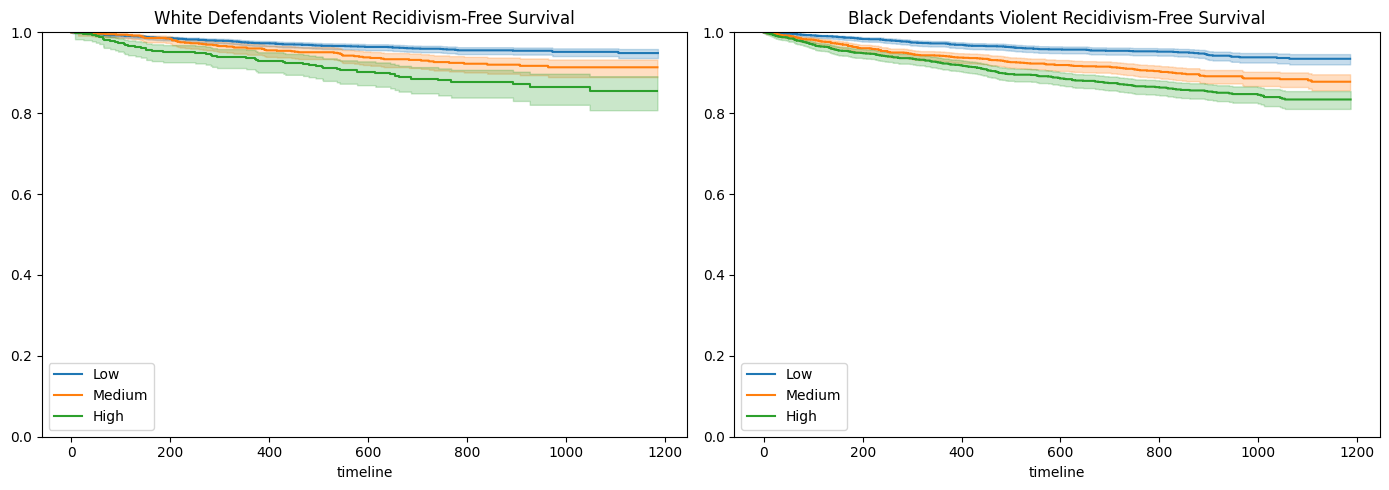

In [103]:
# Race-specific Kaplan-Meier curves for violent recidivism (stratified by score_text)
# Collapse to one row per subject so KM matches R (counting-process data)
def collapse_violent(df):
    return df.groupby('id').agg({'end': 'max', 'event': 'max', 'score_text': 'first', 'race': 'first'}).reset_index()
violent_white_km = collapse_violent(violent_white)
violent_black_km = collapse_violent(violent_black)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for score_label in ['Low', 'Medium', 'High']:
    w = violent_white_km[violent_white_km['score_text'] == score_label]
    if len(w) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(durations=w['end'], event_observed=w['event'], label=score_label)
        kmf.plot_survival_function(ax=ax1)
    b = violent_black_km[violent_black_km['score_text'] == score_label]
    if len(b) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(durations=b['end'], event_observed=b['event'], label=score_label)
        kmf.plot_survival_function(ax=ax2)

ax1.set_title('White Defendants Violent Recidivism-Free Survival')
ax1.set_ylim(0, 1)
ax1.legend()
ax2.set_title('Black Defendants Violent Recidivism-Free Survival')
ax2.set_ylim(0, 1)
ax2.legend()
plt.tight_layout()
plt.show()

## Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [114]:
from sys import stdout
from csv import DictReader, DictWriter


class PeekyReader:
    def __init__(self, reader):
        self.peeked = None
        self.reader = reader

    def peek(self):
        if self.peeked is None:
            self.peeked = next(self.reader)
        return self.peeked

    def __iter__(self):
        return self

    def __next__(self):
        if self.peeked is not None:
            ret = self.peeked
            self.peeked = None
            return ret
        try:
            return next(self.reader)
        except StopIteration:
            self.peeked = None
            raise StopIteration


class Person:
    def __init__(self, reader):
        self.__rows = []
        self.__idx = reader.peek()['id']
        try:
            while reader.peek()['id'] == self.__idx:
                self.__rows.append(next(reader))
        except StopIteration:
            pass

    @property
    def lifetime(self):
        memo = 0
        for it in self.__rows:
            memo += int(it['end']) - int(it['start'])
        return memo

    @property
    def recidivist(self):
        return (self.__rows[0]['is_recid'] == "1" and
                self.lifetime <= 730)

    @property
    def violent_recidivist(self):
        return (self.__rows[0]['is_violent_recid'] == "1" and
                self.lifetime <= 730)

    @property
    def low(self):
        return self.__rows[0]['score_text'] == "Low"

    @property
    def high(self):
        return not self.low

    @property
    def low_med(self):
        return self.low or self.score == "Medium"

    @property
    def true_high(self):
        return self.score == "High"

    @property
    def vlow(self):
        return self.__rows[0]['v_score_text'] == "Low"

    @property
    def vhigh(self):
        return not self.vlow

    @property
    def vlow_med(self):
        return self.vlow or self.vscore == "Medium"

    @property
    def vtrue_high(self):
        return self.vscore == "High"

    @property
    def score(self):
        return self.__rows[0]['score_text']

    @property
    def vscore(self):
        return self.__rows[0]['v_score_text']

    @property
    def race(self):
        return self.__rows[0]['race']

    @property
    def valid(self):
        return (self.__rows[0]['is_recid'] != "-1" and
                (self.recidivist and self.lifetime <= 730) or
                self.lifetime > 730)

    @property
    def compas_felony(self):
        return 'F' in self.__rows[0]['c_charge_degree']

    @property
    def score_valid(self):
        return self.score in ["Low", "Medium", "High"]

    @property
    def vscore_valid(self):
        return self.vscore in ["Low", "Medium", "High"]

    @property
    def rows(self):
        return self.__rows


def count(fn, data):
    return len(list(filter(fn, list(data))))


def t(tn, fp, fn, tp):
    surv = tn + fp
    recid = tp + fn
    print("           \tLow\tHigh")
    print("Survived   \t%i\t%i\t%.2f" % (tn, fp, surv / (surv + recid)))
    print("Recidivated\t%i\t%i\t%.2f" % (fn, tp, recid / (surv + recid)))
    print("Total: %.2f" % (surv + recid))
    print("False positive rate: %.2f" % (fp / surv * 100))
    print("False negative rate: %.2f" % (fn / recid * 100))
    spec = tn / (tn + fp)
    sens = tp / (tp + fn)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    prev = recid / (surv + recid)
    print("Specificity: %.2f" % spec)
    print("Sensitivity: %.2f" % sens)
    print("Prevalence: %.2f" % prev)
    print("PPV: %.2f" % ppv)
    print("NPV: %.2f" % npv)
    print("LR+: %.2f" % (sens / (1 - spec)))
    print("LR-: %.2f" % ((1-sens) / spec))


def table(recid, surv, prefix=''):
    tn = count(lambda i: getattr(i, prefix + 'low'), surv)
    fp = count(lambda i: getattr(i, prefix + 'high'), surv)
    fn = count(lambda i: getattr(i, prefix + 'low'), recid)
    tp = count(lambda i: getattr(i, prefix + 'high'), recid)
    t(tn, fp, fn, tp)


def hightable(recid, surv, prefix=''):
    tn = count(lambda i: getattr(i, prefix + 'low_med'), surv)
    fp = count(lambda i: getattr(i, prefix + 'true_high'), surv)
    fn = count(lambda i: getattr(i, prefix + 'low_med'), recid)
    tp = count(lambda i: getattr(i, prefix + 'true_high'), recid)
    t(tn, fp, fn, tp)


def vtable(recid, surv):
    table(recid, surv, prefix='v')


def vhightable(recid, surv):
    hightable(recid, surv, prefix='v')


def is_race(race):
    return lambda x: x.race == race


def write_two_year_file(f, pop, test, headers):
    headers = list(headers)
    headers.append('two_year_recid')
    with open(f, 'w') as o:
        writer = DictWriter(o, fieldnames=headers)
        writer.writeheader()
        for person in pop:
            row = person.rows[0]
            if getattr(person, test):
                row['two_year_recid'] = 1
            else:
                row['two_year_recid'] = 0

            if person.compas_felony:
                row['c_charge_degree'] = 'F'
            else:
                row['c_charge_degree'] = 'M'
            writer.writerow(row)
            stdout.write('.')


def create_two_year_files():
    people = []
    headers = []
    with open("datasets/compas-analysis/cox-parsed.csv") as f:
        reader = PeekyReader(DictReader(f))
        try:
            while True:
                p = Person(reader)
                if p.valid:
                    people.append(p)
        except StopIteration:
            pass
        headers = reader.reader.fieldnames

    pop = list(filter(lambda i: (i.recidivist and i.lifetime <= 730) or
                      i.lifetime > 730,
                      filter(lambda x: x.score_valid, people)))

    vpop = list(filter(lambda i: (i.violent_recidivist and i.lifetime <= 730) or
                       i.lifetime > 730,
                       filter(lambda x: x.vscore_valid, people)))

    write_two_year_file("./compas-scores-two-years.csv", pop,
                        'recidivist', headers)
    write_two_year_file("./compas-scores-two-years-violent.csv", vpop,
                        'violent_recidivist', headers)


In [116]:
from csv import DictReader

people = []
with open("datasets/compas-analysis/cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]



In [117]:
print("All defendants")
table(list(recid), list(surv))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [118]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

Total pop: 7214


In [56]:
print(f"Total pop: {len(pop)}")

Total pop: 13356


In [119]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [120]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))


Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


That number is higher for African Americans at 44.85%.

In [121]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


And lower for whites at 23.45%.

In [122]:
44.85 / 23.45


1.9125799573560769

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [61]:
47.72 / 27.99

1.7048946052161487

In [123]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [124]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


## Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [125]:
vpeople = []
with open("datasets/compas-analysis/cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]


In [126]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	4121	1597	0.89
Recidivated	347	389	0.11
Total: 6454.00
False positive rate: 27.93
False negative rate: 47.15
Specificity: 0.72
Sensitivity: 0.53
Prevalence: 0.11
PPV: 0.20
NPV: 0.92
LR+: 1.89
LR-: 0.65


In [127]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	1692	1043	0.86
Recidivated	170	273	0.14
Total: 3178.00
False positive rate: 38.14
False negative rate: 38.37
Specificity: 0.62
Sensitivity: 0.62
Prevalence: 0.14
PPV: 0.21
NPV: 0.91
LR+: 1.62
LR-: 0.62


In [128]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	1679	380	0.91
Recidivated	129	77	0.09
Total: 2265.00
False positive rate: 18.46
False negative rate: 62.62
Specificity: 0.82
Sensitivity: 0.37
Prevalence: 0.09
PPV: 0.17
NPV: 0.93
LR+: 2.03
LR-: 0.77


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [129]:
38.14 / 18.46

2.066088840736728

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [130]:
62.62 / 38.37

1.63200416992442

## Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

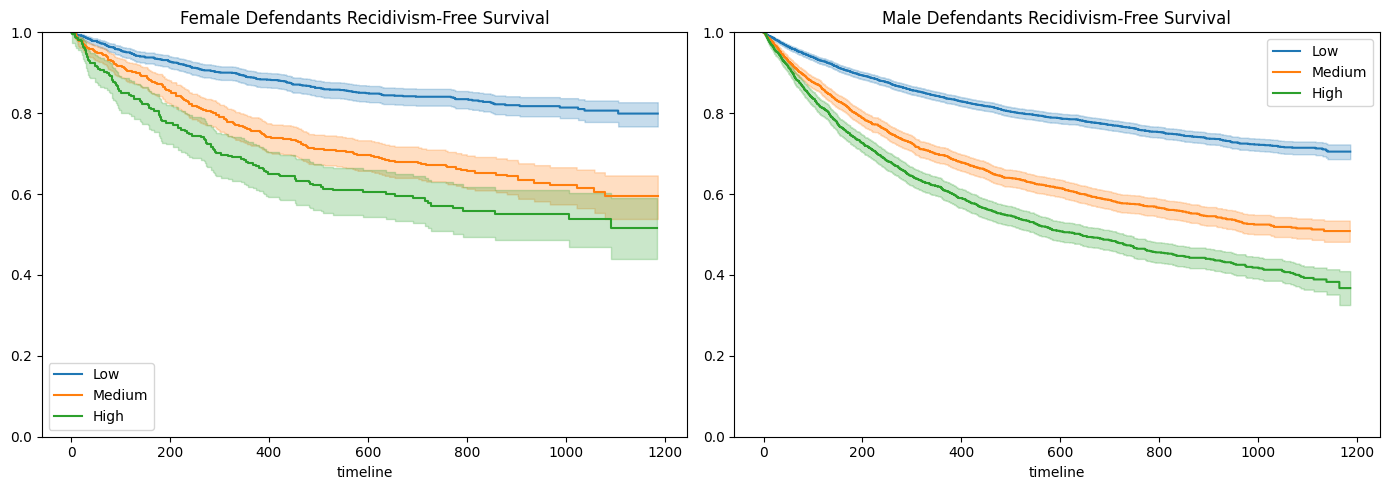

In [ ]:
# Gender-specific survival analysis (stratified by score_text: Low, Medium, High)
# Collapse to one row per subject so KM matches R (run race KM cell first for collapse_to_one_per_id)
female_cox = collapse_to_one_per_id(cox_data[cox_data['sex'] == 'Female'])
male_cox = collapse_to_one_per_id(cox_data[cox_data['sex'] == 'Male'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for score_label in ['Low', 'Medium', 'High']:
    f = female_cox[female_cox['score_text'] == score_label]
    if len(f) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(durations=f['end'], event_observed=f['event'], label=score_label)
        kmf.plot_survival_function(ax=ax1)
    m = male_cox[male_cox['score_text'] == score_label]
    if len(m) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(durations=m['end'], event_observed=m['event'], label=score_label)
        kmf.plot_survival_function(ax=ax2)

ax1.set_title('Female Defendants Recidivism-Free Survival')
ax1.set_ylim(0, 1)
ax1.legend()
ax2.set_title('Male Defendants Recidivism-Free Survival')
ax2.set_ylim(0, 1)
ax2.legend()
plt.tight_layout()
plt.show()

As these plots show, the Compas score treats a High risk women the same as a Medium risk man.